In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from load import get_measures
from load import load_data
from load import train_test_split

In [2]:
# load models forecasts
df = pd.DataFrame()
for file in os.listdir("validation"):
    file_name = "validation/" + file
    df2 = pd.read_csv(file_name, index_col = "date")
    df2.columns = [file[:-7]]
    df = pd.concat([df, df2], axis = 1)

In [37]:
# load "actual" data
test = train_test_split(load_data(), 31)[1]
test.index = df.index
test.columns = ["test"]

In [38]:
df2 = pd.concat([df, test], axis = 1)
df2.head(3)

,auto_arima,decision_trees,test
date,,,
2022-05-01,9199.879992,8918.050667,8794.163125
2022-05-02,12129.336925,10351.305465,11643.821542
2022-05-03,12613.390092,10842.369542,11941.662583


In [36]:
dict_metrics = []
for model in df2.columns:
    if model == "test":
        continue
    else:
        measures = get_measures(df2[model], df2["test"])
        measures["model"] = model
        dict_metrics.append(measures)
df2_metrics = pd.DataFrame(dict_metrics)   
temp_cols = df2_metrics.columns.to_list()
new_col_order = temp_cols[-1:] + temp_cols[:-1]
df2_metrics = df2_metrics[new_col_order]
df2_metrics

,model,erro,mae,mse,rmse,mape,smape
0,auto_arima,19407070.36,703.80,626034.53,791.22,0.06,6.22
1,decision_trees,7720545.89,373.82,249049.87,499.05,0.03,3.29


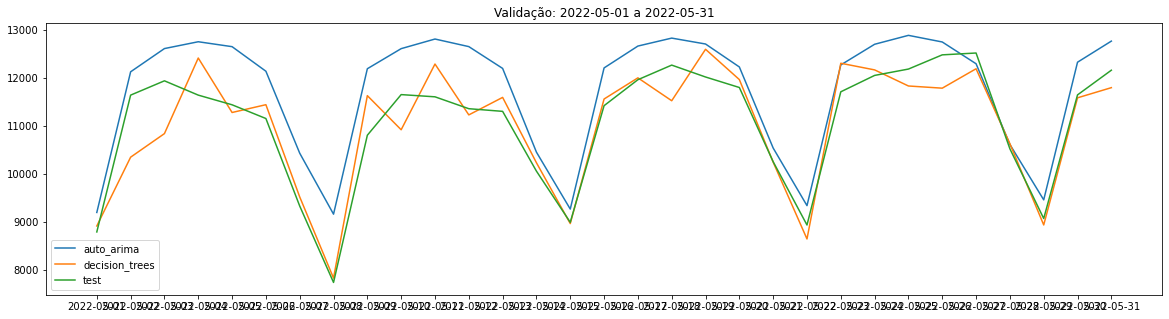

In [40]:
plt.figure(figsize = (20,5))

for model in df2.columns:
    plt.plot(df2[model], label = model)

date_init = df2.index[0]
date_end = df2.index[-1]
plt.title(f"Validação: {date_init} a {date_end}")
plt.legend()

plt.show()